In [2]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

LOAD THE DATA AND SEPARATE INTO TRAIN/TEST DATA

In [3]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [4]:
x_train, y_train, x_test, y_test, class_names = load_data('data_npy')

In [5]:
num_classes = len(class_names)
image_size = 28

Show some random data

dau_hoi


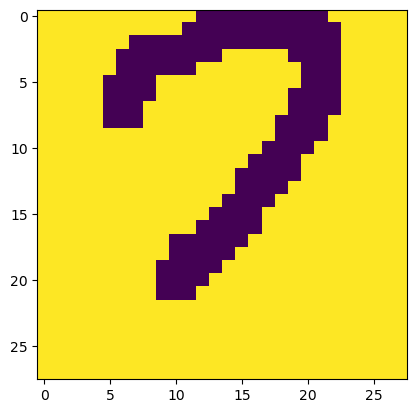

In [6]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

PREPROCESSING THE DATA

In [7]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

MODEL #1

In [8]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(5, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy', 'accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

TRAINING WITH MODEL #1

In [9]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1/1 - 1s - loss: 1.6302 - top_k_categorical_accuracy: 1.0000 - accuracy: 0.2500 - val_loss: 1.6427 - val_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2000 - 1s/epoch - 1s/step
Epoch 2/5
1/1 - 0s - loss: 1.6060 - top_k_categorical_accuracy: 1.0000 - accuracy: 0.2000 - val_loss: 1.6243 - val_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.2000 - 50ms/epoch - 50ms/step
Epoch 3/5
1/1 - 0s - loss: 1.5843 - top_k_categorical_accuracy: 1.0000 - accuracy: 0.2125 - val_loss: 1.5945 - val_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.3000 - 54ms/epoch - 54ms/step
Epoch 4/5
1/1 - 0s - loss: 1.5548 - top_k_categorical_accuracy: 1.0000 - accuracy: 0.3875 - val_loss: 1.5780 - val_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.5500 - 47ms/epoch - 47ms/step
Epoch 5/5
1/1 - 0s - loss: 1.5345 - top_k_categorical_accuracy: 1.0000 - accuracy: 0.7125 - val_loss: 1.5665 - val_top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.4000 - 51ms/epoch - 51ms/step


TESTING WITH MODEL #1

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))
print('Test loss: {:0.2f}%'.format(score[0] * 100))

Test accuracy: 100.00%
Test loss: 156.65%


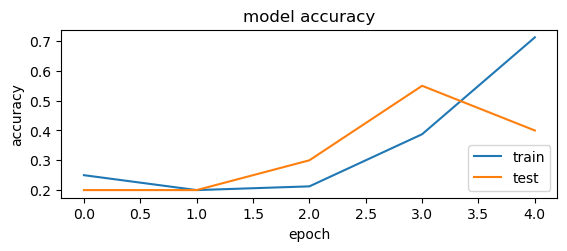

In [11]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

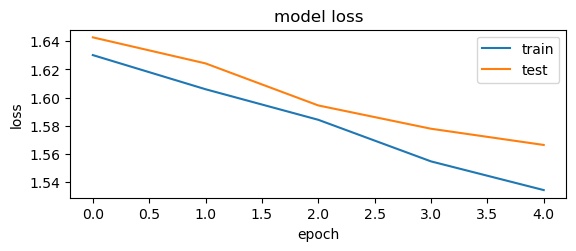

In [12]:
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

INFERENCE

1/1 [==============================] - 0s 31ms/step
['dau_nang', 'dau_huyen', 'dau_sac', 'dau_nga', 'dau_hoi']


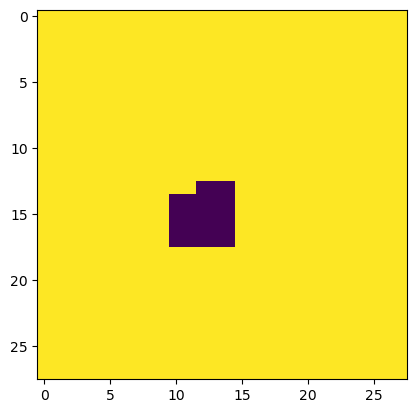

In [38]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

SAVE MODEL #1

In [14]:
model_save_name = 'tonal_symbol1.h5'
path = F"./models/{model_save_name}"

model.save(path)

STORE CLASSES

In [39]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))